# Notebook for Testing the plotting of CLV Data for the PO Model

### Imports

In [170]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, jit, prange
import itertools

mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

### Open Data File

In [171]:
## System Parameters
N       = 256
k0      = 1
alpha   = 3.45
beta    = 0.0 
iters   = 400000
m_end   = 8000
m_iters = 50
trans   = 100000
u0      = "RANDOM"


In [172]:
## Read open data file
results_dir = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]".format(N, k0, alpha, beta, u0)
filename    = "/CLVData_ITERS[{},{},{}]_TRANS[{}]".format(iters, m_end, m_iters, trans)

input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS/" + results_dir

In [173]:
HDFfileData = h5py.File(input_dir + results_dir + filename + '.h5', 'r')
print("\n\nData File: {}.h5\n".format(results_dir + filename))



Data File: /RESULTS_N[256]_k0[1]_ALPHA[3.450]_BETA[0.000]_u0[RANDOM]/CLVData_ITERS[400000,8000,50]_TRANS[100000].h5



### Read In Data

In [174]:
## Read in datasets
phases = HDFfileData['Phases'][:, :]
time   = HDFfileData['Time'][:]
amps   = HDFfileData['Amps'][:]
lce    = HDFfileData['LCE'][:, :]
CLVs   = HDFfileData['CLVs']
angle = HDFfileData['Angles']

## System Parameters
num_tsteps = len(time);
num_clv_steps = CLVs.shape[0]
num_osc    = amps.shape[0];
kmin       = k0 + 1;
kmax       = num_osc - 1;
dof        = num_osc - kmin

In [175]:
## Reshape the CLV data
clv_dims = CLVs.attrs['CLV_Dims']
CLV      = np.reshape(CLVs, (CLVs.shape[0], dof, dof))
ang_dims = angle.attrs['Angle_Dims']
angles   = np.reshape(angle, (angle.shape[0], dof, dof))

### Compute Angles Between Vectors

In [127]:
@jit(nopython = True)
def compute_angles_t(clv, num_tsteps, dof):
    angles = np.zeros((num_tsteps, dof, dof))
    
    for t in range(num_tsteps):
        for i in range(dof):
            for j in range(i):
                mat = np.transpose(CLV[t, :, :])
                angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[i, :], mat[j, :])))
    
    return angles

In [128]:
@jit(nopython = True)
def compute_angles(clv, num_tsteps, dof):
    angles = np.zeros((num_tsteps, dof, dof))
    
    for t in range(num_tsteps):
        for i in range(dof):
            for j in range(i):
                mat = CLV[t, :, :]
                angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[:, i], mat[:, j])))
    
    return angles

In [9]:
# %%timeit 
# angles = compute_angles_t(CLV, num_clv_steps, dof)
# print(angles.shape)

In [10]:
# %%timeit
# angles = compute_angles(CLV, num_clv_steps, dof)
# angles.shape

### Compute the Squared Time Averaged Lyapunov Vector Components

In [11]:
@jit(nopython = True)
def compute_zdata(clv, num_tsteps, dof):
    
    z_data   = np.zeros((dof, dof))
    
    for t in range(num_tsteps):
        z_data += np.square(clv[t, :, :])
    
    z_data = z_data / num_tsteps
    
    return z_data

In [163]:
zdata = compute_zdata(CLV, num_clv_steps, dof)

In [176]:
# find the zero Lyap Exp
minval  = np.amin(np.absolute(lce[-1, :]))
minindx = np.where(np.absolute(lce[-1, :]) == minval)
minindx_el,  = minindx
print(minindx_el)
zeroindx = minindx_el[0]

# Extract positive and neg Exponents
lce_pos = lce[-1, :minindx_el[0]]
lce_neg = lce[-1, minindx_el[0] + 1:]

# Extract positive and negative vectors
CLV_expand   = CLV[0, :, :minindx_el[0]]
CLV_zero     = CLV[0, :, :minindx_el[0]]
CLV_contract = CLV[0, :, minindx_el[0] + 1:]

[6]


In [233]:
@jit(nopython = True)
def compute_energy(clv, num_tsteps, dof):
    
    even = np.zeros((num_tsteps))
    odd  = np.zeros((num_tsteps))
    
    for t in range(num_tsteps):
        even[t] = np.linalg.norm(clv[t, ::2, :])
        odd[t]  = np.linalg.norm(clv[t, 1::2, :])
            
    return even, odd

In [234]:
even_data, odd_data = compute_energy(CLV, num_clv_steps, dof)

In [236]:
def compute_angles_subspaces(A1, B1, num_clv_steps):
    
    angles1 = np.zeros((num_clv_steps))
    
    for t in range(0, num_clv_steps):
        angles1[t] = subspace_angles(A1[t, :, :], B1[t, :, :])[0]
        
    return angles1

In [144]:
# %%timeit
theta1 = compute_angles_subspaces(CLV[:, :, :zeroindx + 1], CLV[:, :, zeroindx + 1:], num_clv_steps)
if zeroindx > 0:
    theta2 = compute_angles_subspaces(CLV[:, :, :zeroindx], CLV[:, :, zeroindx:], num_clv_steps)

## Plot the Data

### Squared Time Averaged Lyapunov Vector Components

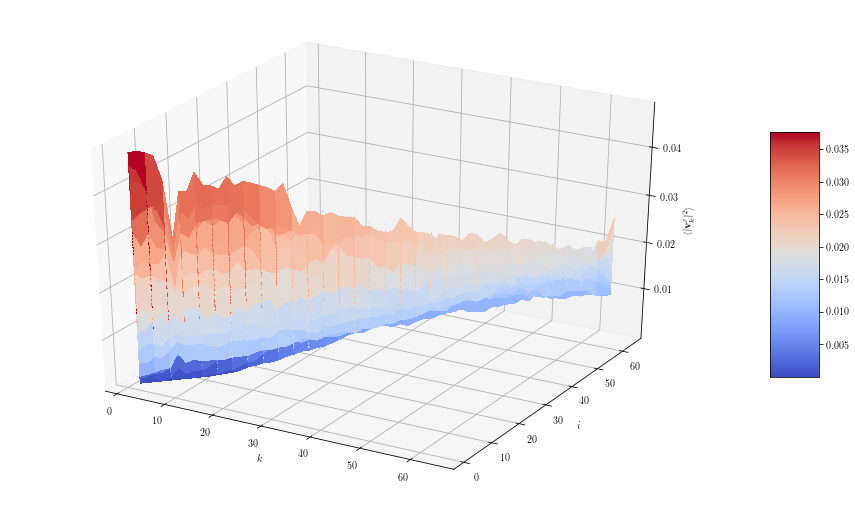

In [21]:
fig = plt.figure(figsize = (16, 9))
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(range(kmin, num_osc), range(1, dof + 1), np.flipud(zdata), cmap = cm.coolwarm, linewidth = 0, antialiased = False) 
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$i$")
ax.set_zlabel(r"$\langle |\mathbf{v}_k^j |^2\rangle$")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()

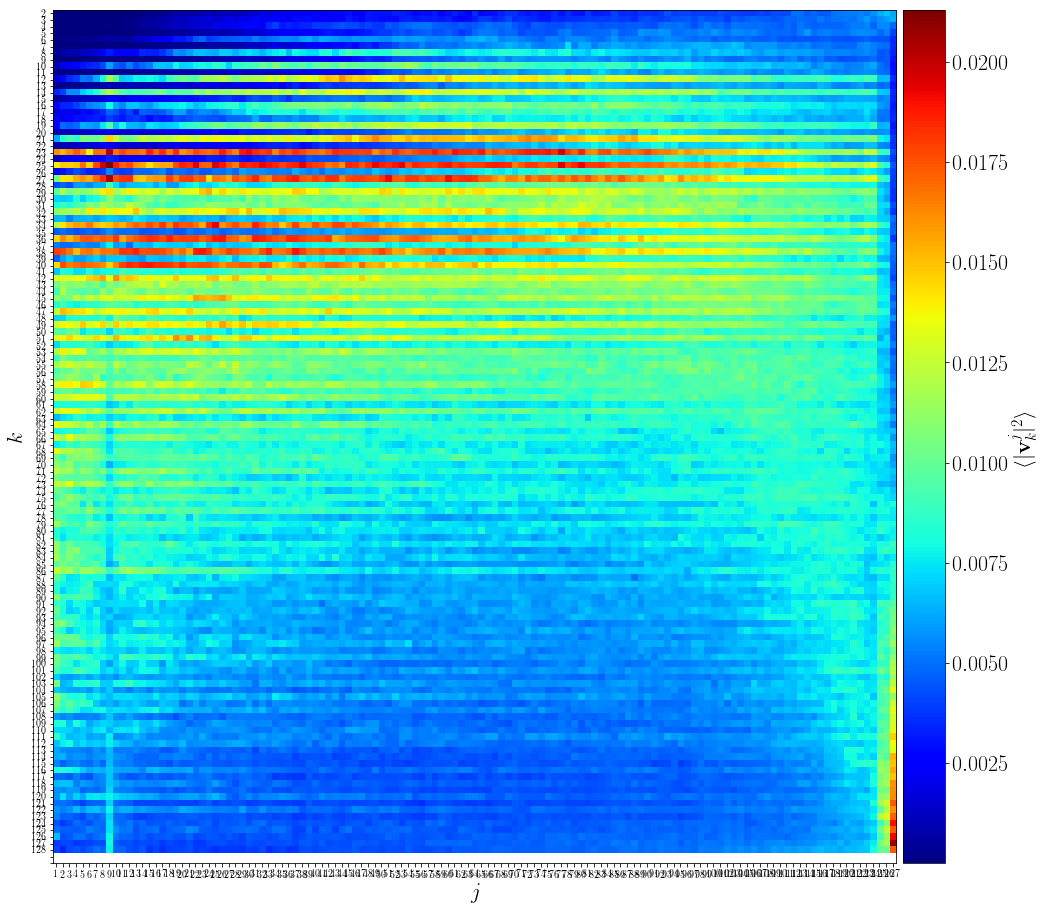

In [237]:
fig = plt.figure(figsize = (16, 16), tight_layout = False)
gs  = GridSpec(1, 1, wspace = 0.35)

ax2 = fig.add_subplot(gs[0, 0])
im  = ax2.imshow(zdata, cmap = cm.jet)#extent = [1, dof, kmin, num_osc]
ax2.set_xlabel(r"$j$")
ax2.set_ylabel(r"$k$")
ax2.set_yticks(np.arange(0, num_osc))
ax2.set_yticklabels(np.arange(kmin, num_osc), fontsize = 10)
ax2.set_xticks(np.arange(0, dof))
ax2.set_xticklabels(np.arange(1, dof + 1), fontsize = 10)
div2  = make_axes_locatable(ax2)
cax2  = div2.append_axes('right', size = '5%', pad = 0.1)
cbar = plt.colorbar(im, cax = cax2, orientation = 'vertical')
cbar.set_label(r"$\langle |\mathbf{v}_k^j |^2\rangle$")
# ax21  = div2.append_axes('left', size = '5%', pad = 0.8, sharey = ax2)
# ax22  = div2.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax2)
# for i in range(1, dof + 1):
#     if i == zeroindx:
# #         ax21.plot(0.5, i + 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o')
#         ax22.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
#     elif i < zeroindx: 
# #         ax21.plot(0.5, i + 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof)
#         ax22.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
#     elif i > zeroindx: 
# #         ax21.plot(0.5, i + 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof)
#         ax22.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
# # ax21.set_ylim(1, dof)
# ax22.set_xlim(1, dof)
# # ax21.axis("off")
# ax22.axis("off")


# ax3 = fig.add_subplot(gs[0, 1])
# ax3.plot(even_data)
# ax3.plot(odd_data)
# ax3.set_xlabel(r"$t$")
# ax3.set_ylabel(r"$\| \mathbf{v}_k\|$")
# ax3.legend([r"$k = $ even", r"$k = $ odd"])


# plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/TimeAverage.pdf")  
# plt.close()

plt.show()


In [238]:
@njit
def compute_pop_phase_order(phases, kmin, kmax, num_tsteps):
    
    phase_order = np.complex(0.0, 0.0) * np.zeros((num_tsteps))

    for t in range(num_tsteps):
        num_phases = 0
        order_sum  = np.complex(0.0, 0.0)
        for k in range(phases.shape[1]):
            order_sum  += np.exp(np.complex(0.0, 1.0) * phases[t, k]) # np.mod(phases[t, k], 2.0 * np.pi)
            num_phases += 1
        phase_order[t] = order_sum / num_phases
        
    return phase_order

In [239]:
even_pop = compute_pop_phase_order(phases[:, 2::2], kmin, kmax, phases.shape[0])
odd_pop = compute_pop_phase_order(phases[:, 3::2], kmin, kmax, phases.shape[0])

In [ ]:
indep_triads = np.zeros((phases.shape[0], int(N/2 - 3)))

for i in range(phases.shape[1] - 2*kmin):
    indep_triads[:, i] = phases[:, 2] + phases[:, 2 + i] - phases[:, 4 + i]
#     print(2, 2 + i, 4 + i)
    
for k in range(kmin , int(kmax/6) + 1):
    for k1 in range(kmin, int(k / 2) + 1):
        print("({}, {}, {})".format(k1, k - k1, k), end = '  ')        
    print()

Text(0.5,1,'Most Unstable Lyapunov Vector')

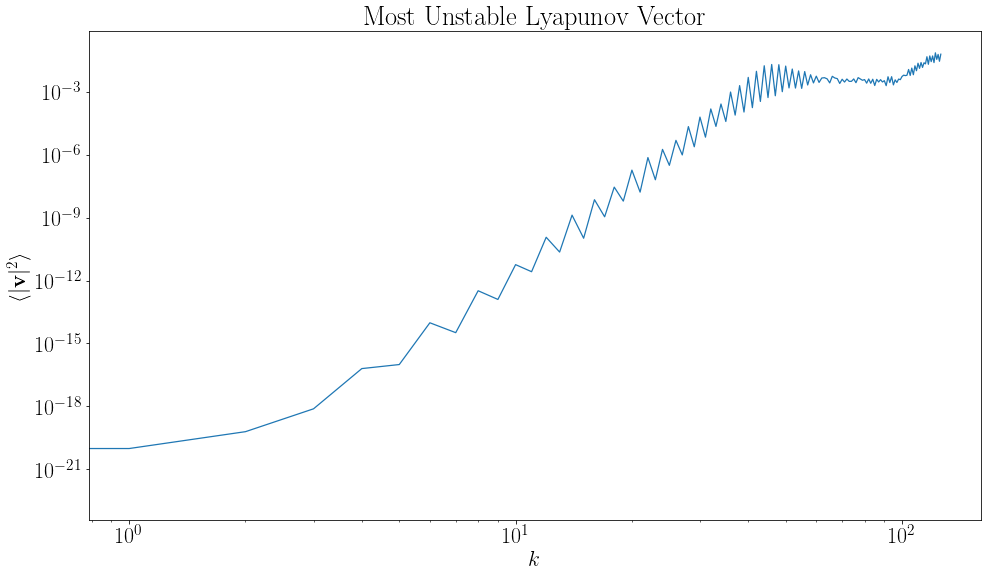

In [169]:
fig = plt.figure(figsize = (16, 9), tight_layout = False)
gs  = GridSpec(1, 1)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(zdata[:, 0])
ax1.set_xticks(np.arange(0, dof, 6))
ax1.set_xticklabels(np.arange(kmin, num_osc, 6))
# ax1.axvspan(reg1_l, reg1_r, alpha = 0.25, color='grey')
# ax1.axvline(x = reg1_l, color = 'black')
# ax1.axvline(x = reg1_r, color = 'black')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\langle |\mathbf{v}|^2\rangle$")
ax1.set_title(r"Most Unstable Lyapunov Vector")

In [153]:
k = 20
for i in range(15, 26):
    plt.figure()
    if i != 20:
        plt.plot(indep_triads[:, i], indep_triads[:, k], '.')
        ymin, ymax = plt.gca().get_ylim()
        xmin, xmax = plt.gca().get_xlim()
        theta = np.pi / 2
        j = 0
        while(theta * j <= xmax):
            plt.axvline(x = theta * j, linestyle = '--', color = "black")
            j += 1
        j = 0
        while(-theta * j >= xmin):
            plt.axvline(x = -theta * j, linestyle = '--', color = "black")
            j += 1
        j = 0
        while(theta * j <= ymax):
            plt.axhline(y = theta * j, linestyle = '--', color = "black")
            j += 1
        j = 0
        while(-theta * j >= ymin):
            plt.axhline(y = -theta * j, linestyle = '--', color = "black")
            j += 1
        plt.xlim(np.amin(indep_triads[:, i]), np.amax(indep_triads[:, i]))
        plt.ylim(np.amin(indep_triads[:, k]), np.amax(indep_triads[:, k]))

        plt.xlabel(r"$\varphi_{{{},{}}}^{{{}}}$".format(2, 2 + i, 4 + i))
        plt.ylabel(r"$\varphi_{{{},{}}}^{{{}}}$".format(2, 2 + k, 4 + k))
    plt.show()

NameError: name 'indep_triads' is not defined

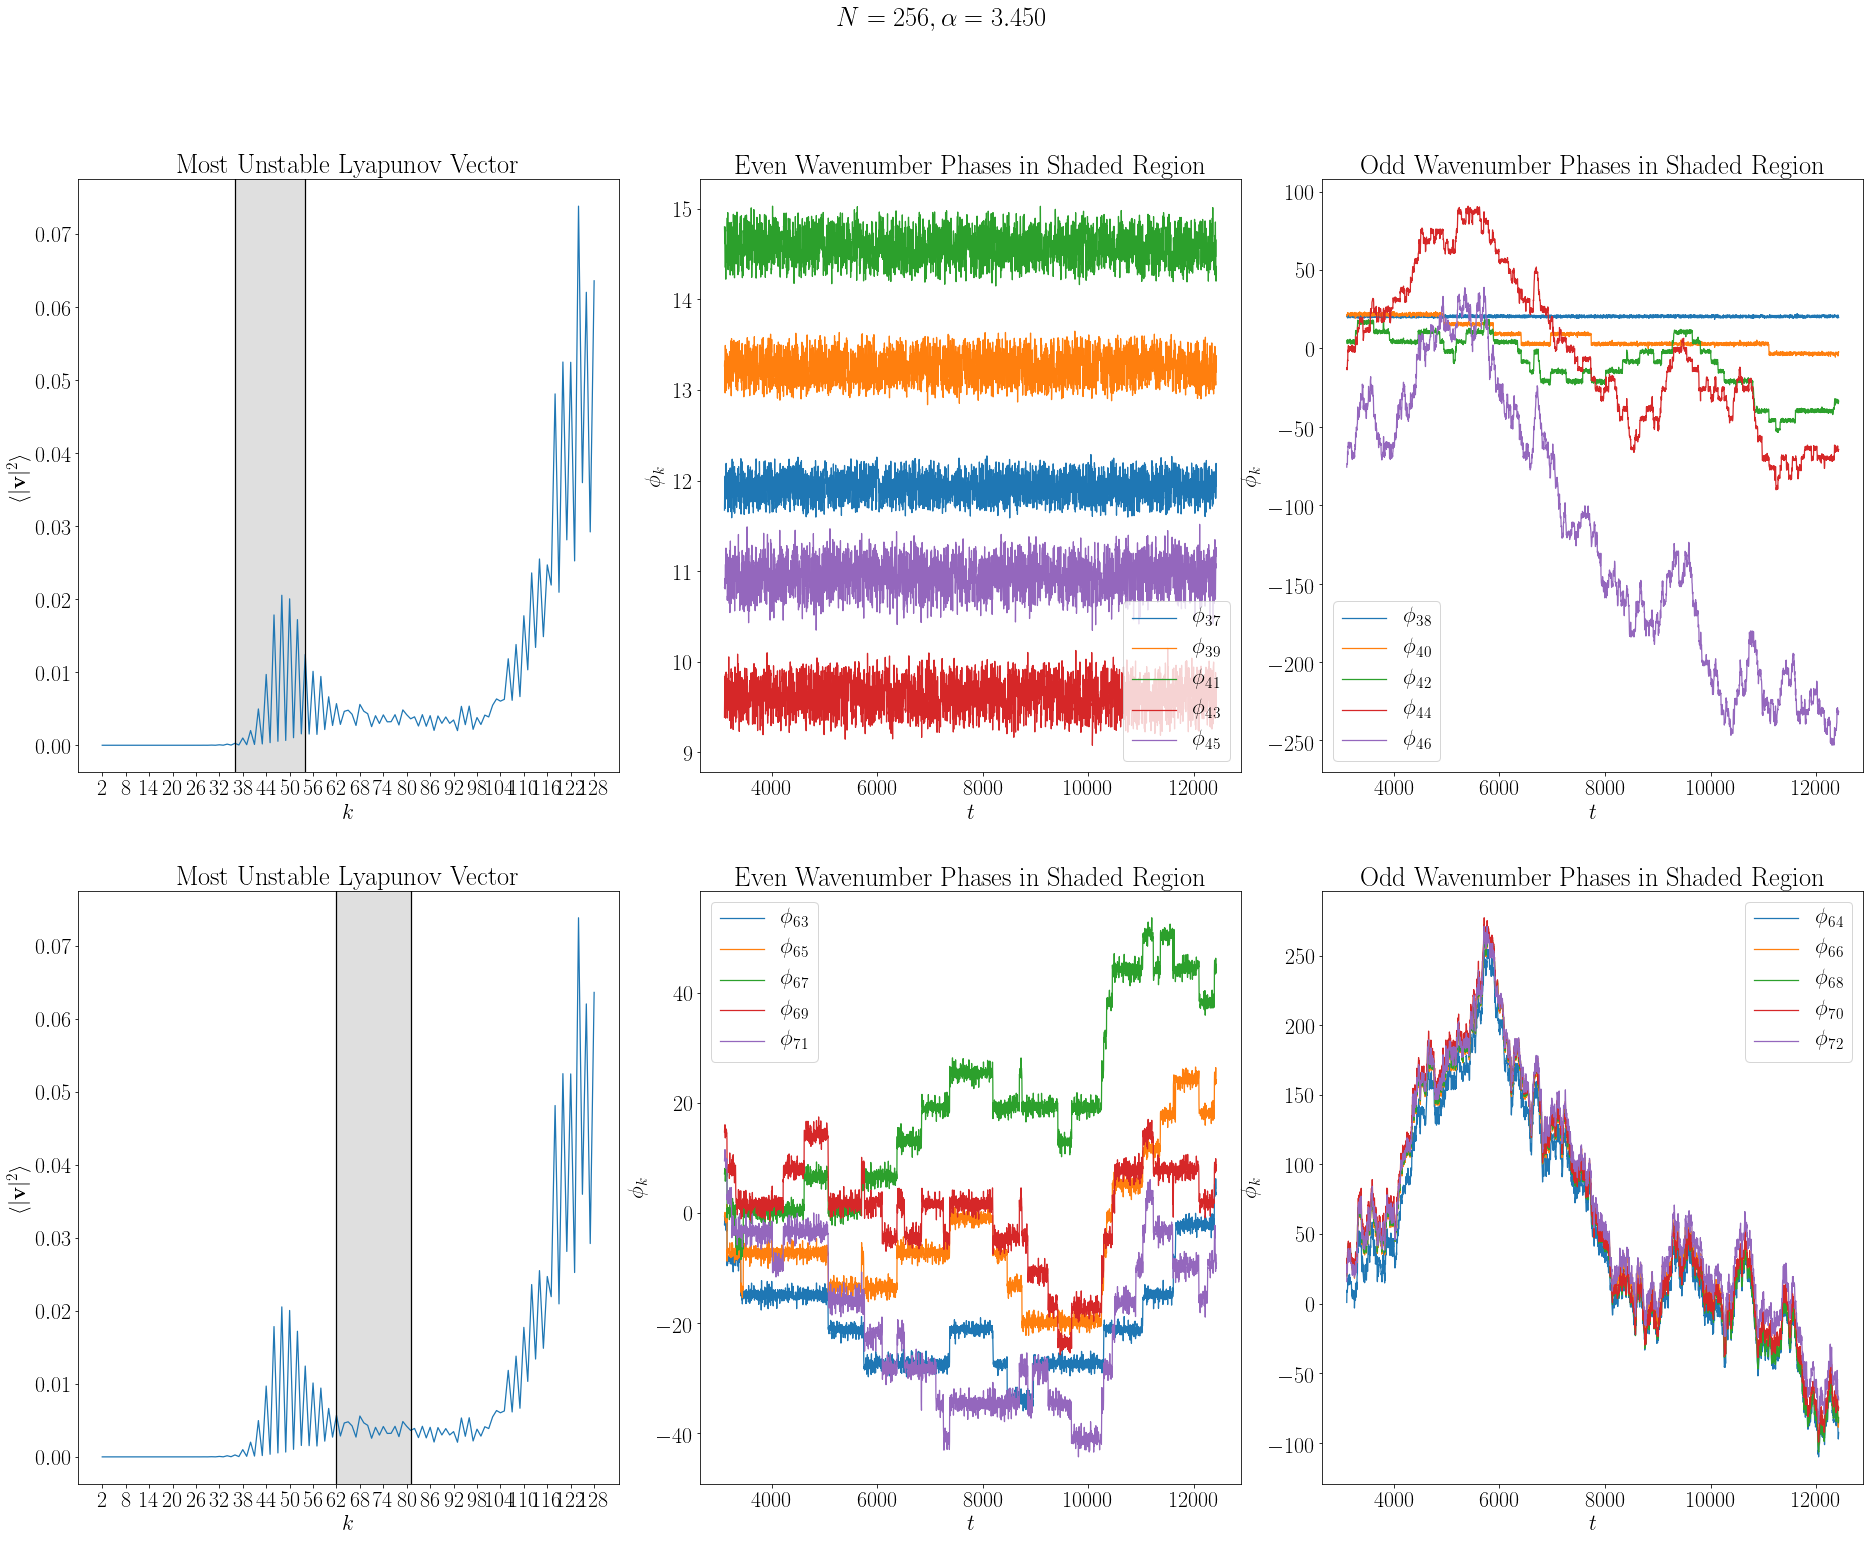

In [156]:
# print(lce[-1, :])
# print(lce[-1, zeroindx])
# print(zeroindx)
# print(CLV[100, :10, :3])

reg1_l = 34
reg1_r = 52

reg2_l = 60
reg2_r = 79

j = 0

fig = plt.figure(figsize = (32, 24), tight_layout = False)
gs  = GridSpec(2, 3, wspace = 0.15)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(zdata[:, j])
ax1.set_xticks(np.arange(0, dof, 6))
ax1.set_xticklabels(np.arange(kmin, num_osc, 6))
ax1.axvspan(reg1_l, reg1_r, alpha = 0.25, color='grey')
ax1.axvline(x = reg1_l, color = 'black')
ax1.axvline(x = reg1_r, color = 'black')
ax1.set_xlabel(r"$k$")
ax1.set_ylabel(r"$\langle |\mathbf{v}|^2\rangle$")
ax1.set_title(r"Most Unstable Lyapunov Vector")
# ax1.set_yscale("log")

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time, phases[:, reg1_l + 3:reg1_l + 13:2])
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\phi_k$")
ax2.set_title(r"Even Wavenumber Phases in Shaded Region")
ax2.legend([r"$\phi_{{{}}}$".format(i) for i in range(reg1_l + 3, reg1_l + 13, 2)])

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(time, phases[:, reg1_l + 4:reg1_l + 14:2])
ax3.set_xlabel(r"$t$")
ax3.set_ylabel(r"$\phi_k$")
ax3.set_title(r"Odd Wavenumber Phases in Shaded Region")
ax3.legend([r"$\phi_{{{}}}$".format(i) for i in range(reg1_l + 4, reg1_l + 14, 2)])


ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(zdata[:, j])
ax4.set_xticks(np.arange(0, dof, 6))
ax4.set_xticklabels(np.arange(kmin, num_osc, 6))
ax4.axvspan(reg2_l, reg2_r, alpha = 0.25, color='grey')
ax4.axvline(x = reg2_l, color = 'black')
ax4.axvline(x = reg2_r, color = 'black')
ax4.set_xlabel(r"$k$")
ax4.set_ylabel(r"$\langle |\mathbf{v}|^2\rangle$")
ax4.set_title(r"Most Unstable Lyapunov Vector")
# ax1.set_yscale("log")

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(time, phases[:, reg2_l + 3:reg2_l + 13:2])
ax5.set_xlabel(r"$t$")
ax5.set_ylabel(r"$\phi_k$")
ax5.set_title(r"Even Wavenumber Phases in Shaded Region")
ax5.legend([r"$\phi_{{{}}}$".format(i) for i in range(reg2_l + 3, reg2_l + 13, 2)])

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(time, phases[:, reg2_l + 4:reg2_l + 14:2])
ax6.set_xlabel(r"$t$")
ax6.set_ylabel(r"$\phi_k$")
ax6.set_title(r"Odd Wavenumber Phases in Shaded Region")
ax6.legend([r"$\phi_{{{}}}$".format(i) for i in range(reg2_l + 4, reg2_l + 14, 2)])

# ax3 = fig.add_subplot(gs[0, 2])
# # ax3.plot(phases[:, 2] + phases[:, 5] - phases[:, 7], phases[:, 3] + phases[:, 5] - phases[:, 8], '.-')
# for i in range(8, 15):
#     ax3.plot(phases[:, 3] + phases[:, 2 + i] - phases[:, i + 4])

# ax3.legend([r"$\varphi_{{{}, {}}}^{{{}}}$".format(2, i + 2, i + 4) for i in range(8, 15)])
# # ax3.plot(phases[:, 3] + phases[:, 3] - phases[:, 6])
# # ax3.plot()
# # ax3.plot(np.absolute(phases[:, 3] - phases[:, 5] + 1) - 1 - np.sin(phases[:, 3]))
# # ax3.plot(phases[:100, 3], phases[:100, 5])
# # ax3.plot(np.sin(phases[:, 20] + phases[:, 22] - phases[:, 24]))
# # ax3.plot(np.sin(phases[:, 3]))
# # ax3.plot(phases[:, 5])
# # ax3.plot(phases[:, 3])
# # ax3.set_ylabel(r"$\phi_k - \phi_j$")
# # ax3.plot(CLV[-100:, 0:v_max - kmin, zeroindx])
# ax3.set_xlabel(r"$t$")
# # ax3.set_ylabel(r"$v_i$")
# # ax3.set_title(r"$[0, {}]$ Components of Zero vector".format(v_max - kmin - 1))

# # ax4 = fig.add_subplot(gs[0, 3])
# # ax4.plot(np.mod(np.angle(even_pop), 2*np.pi))
# # ax4.plot(np.angle(even_pop))
# # ax4.plot(np.absolute(even_pop))
# # ax4.plot(np.angle(odd_pop))
# # ax4.plot(np.absolute(odd_pop))
# ax2.set_xlabel(r"$t$")
# ax4.legend([r"$\Phi_{even}(t)$", r"$\mathcal{R}_{even}(t)$", r"$\Phi_{odd}(t)$", r"$\mathcal{R}_{odd}(t)$"])
plt.suptitle(r"$N = {}, \alpha = {:0.3f}$".format(N, alpha))

plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/CLVs" + "/TSeries_Phases_N[{}]_ALPHA[{:0.3f}].png".format(N, alpha), format = "png")  

plt.show()

# print(phases[10:20, 0:5])
# print(phases.shape)
# print(trans)

### Angles Plots

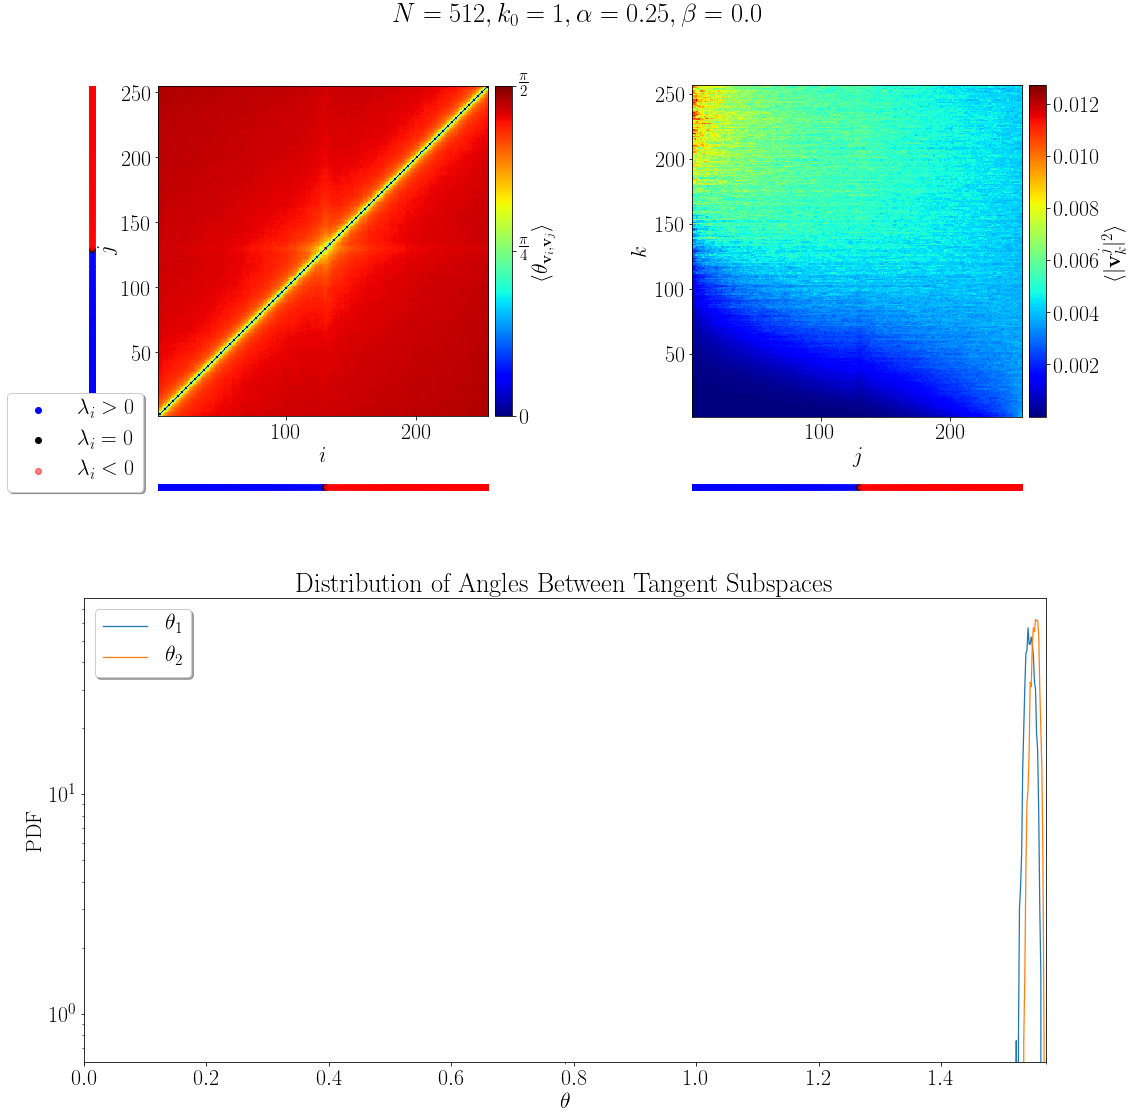

In [24]:
fig = plt.figure(figsize = (16, 16))
gs  = GridSpec(2, 2)

t = 1000

cmap_new = cm.jet
# cmap_new.set_bad(color = 'black')

# Angles
ax1 = fig.add_subplot(gs[0, 0])
data = np.mean(angles[:, :, :], axis = 0)
im1  = ax1.imshow(np.flipud(data + data.T - np.diag(np.diag(data))), cmap = cmap_new, extent = [1, dof, 1, dof], vmin = 0.0, vmax = np.pi/2.0)
ax1.set_xlabel(r"$i$")
ax1.set_ylabel(r"$j$")
div1  = make_axes_locatable(ax1)
cax1  = div1.append_axes('right', size = '5%', pad = 0.1)
cbar1 = plt.colorbar(im1, cax = cax1, orientation = 'vertical')
cbar1.set_ticks([ 0.0, np.pi/4.0, np.pi/2.0])
cbar1.set_ticklabels([r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"])
cbar1.set_label(r"$\langle\theta_{\mathbf{v}_i, \mathbf{v}_j}\rangle$")
ax11  = div1.append_axes('left', size = '5%', pad = 0.8, sharey = ax1)
ax12  = div1.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax1)
for i in range(1, dof + 1):
    if i == zeroindx:
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o')
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof)
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof)
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
ax11.set_ylim(1, dof)
ax12.set_xlim(1, dof)
ax11.axis("off")
ax12.axis("off")
ax12.legend(loc = "lower right", bbox_to_anchor = (-0.01, -0.1), fancybox = True, framealpha = 1, shadow = True)

## Time Averaged
ax2 = fig.add_subplot(gs[0, 1])
im  = ax2.imshow(np.flipud(zdata), cmap = cm.jet, extent = [1, dof, kmin, num_osc])
ax2.set_xlabel(r"$j$")
ax2.set_ylabel(r"$k$")
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size = '5%', pad = 0.1)
cbar = plt.colorbar(im, cax = cax2, orientation = 'vertical')
cbar.set_label(r"$\langle |\mathbf{v}_k^j |^2\rangle$")
ax21  = div2.append_axes('left', size = '5%', pad = 0.8, sharey = ax2)
ax22  = div2.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax2)
for i in range(1, dof + 1):
    if i == zeroindx:
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
ax22.set_xlim(1, dof)
ax21.axis("off")
ax22.axis("off")
plt.suptitle(r"$N = {}, k_0 = {}, \alpha = {}, \beta = {}$".format(N, k0, alpha, beta))


ax3 = fig.add_subplot(gs[1, 0:])
hist, bins  = np.histogram(theta1, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
hist, bins  = np.histogram(theta2, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
ax3.plot(bin_centers, hist)
ax3.set_xlim(0.0, np.pi/2.0)
ax3.set_xlabel(r"$\theta$")
ax3.set_xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
ax3.set_ylabel(r"PDF")
ax3.set_yscale("log")
ax3.legend([r"$\theta_1$", r"$\theta_2$"], fancybox = True, framealpha = 1, shadow = True)
ax3.set_title(r"Distribution of Angles Between Tangent Subspaces")




# # plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/Angles1.pdf")  

plt.tight_layout(rect = (0, 0, 1, 0.96))
plt.show()

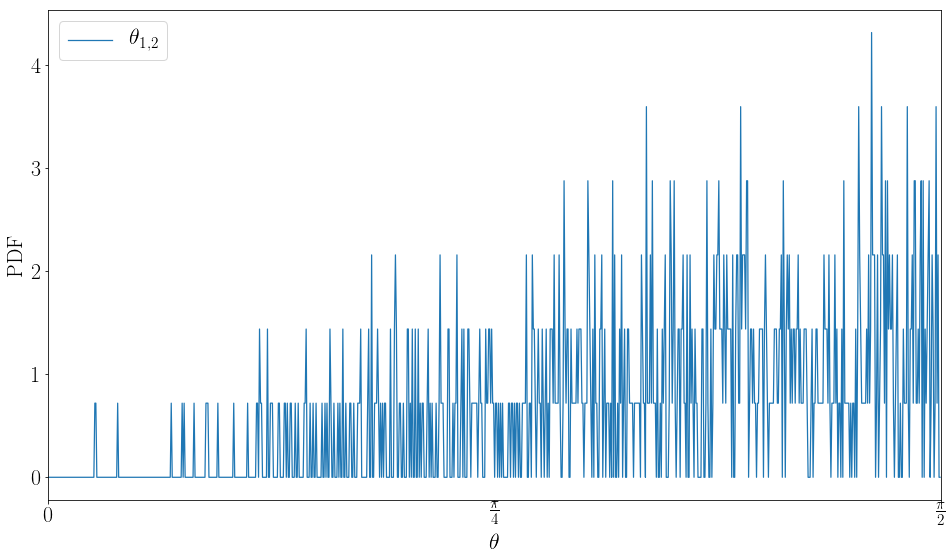

In [785]:
plt.figure()
hist, bins  = np.histogram(angles[:, 6, 3], range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
plt.xlim(0.0, np.pi/2.0)
plt.xlabel(r"$\theta$")
plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
plt.legend([r"$\theta_{1, 2}$"])
plt.ylabel(r"PDF")
plt.show()

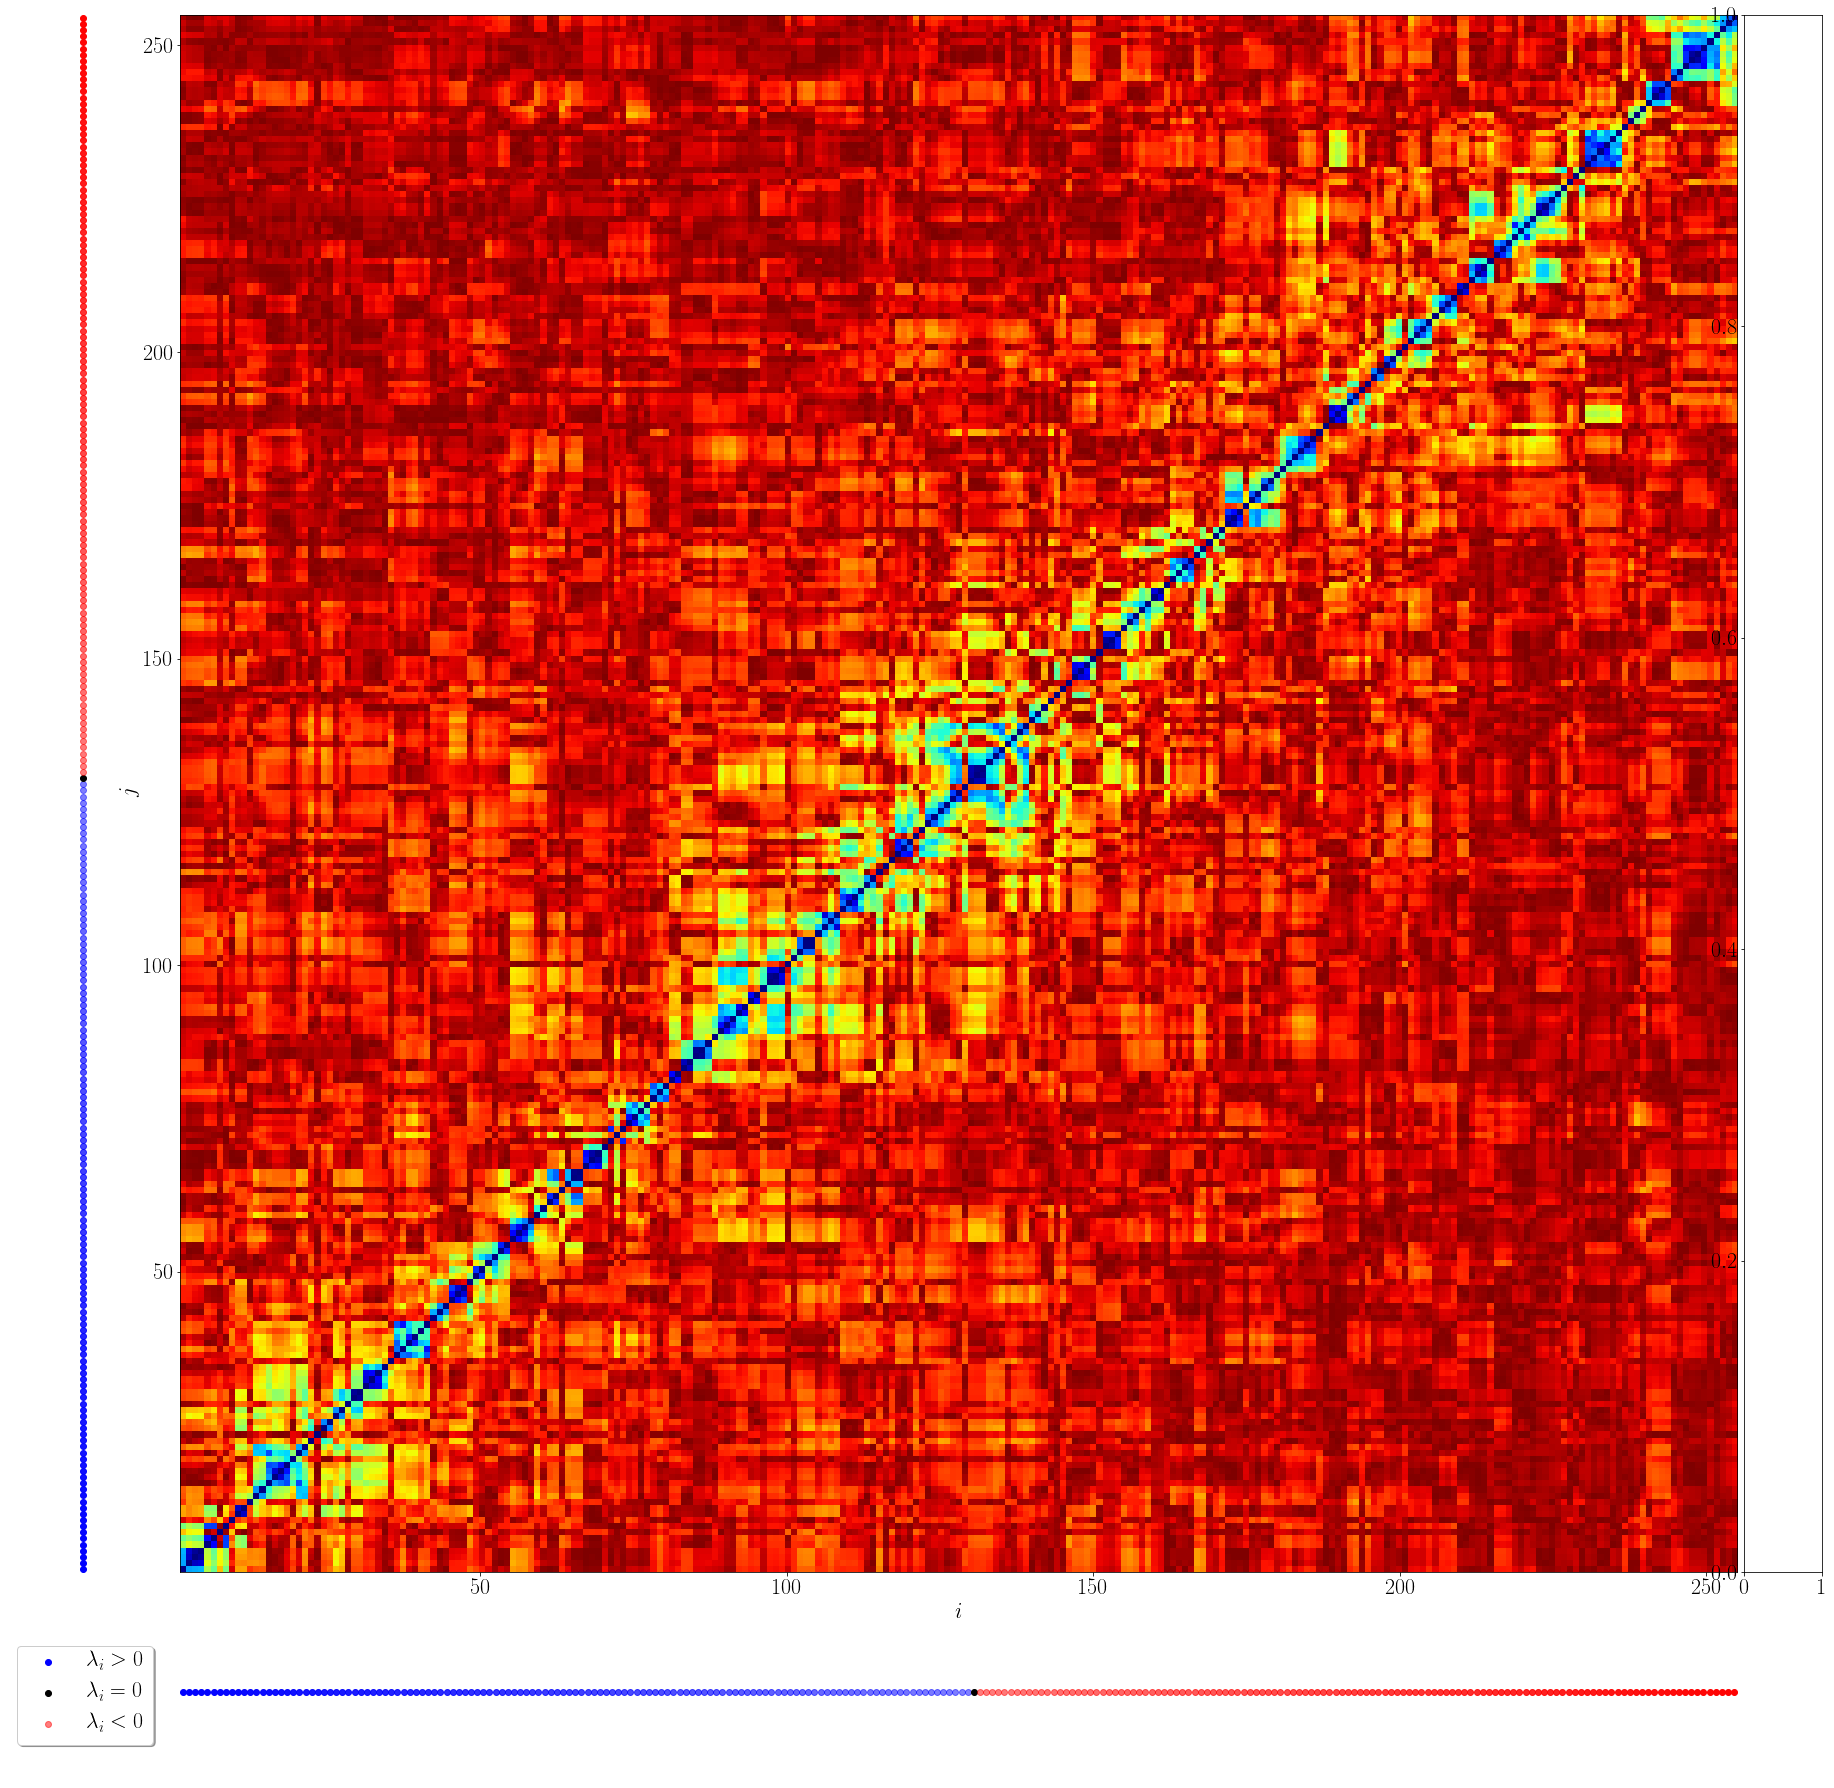

255
257
129


In [25]:
fig = plt.figure(figsize = (32, 32))
gs  = GridSpec(1, 1)

ax1 = fig.add_subplot(gs[0, 0])
im  = ax1.imshow(np.flipud(angles[10, :, :] + angles[10, :, :].T - np.diag(np.diag(angles[10, :, :]))), cmap = cmap_new, extent = [1, dof, 1, dof], vmin = 0.0, vmax = np.pi/2.0)
ax1.set_xlabel(r"$i$")
ax1.set_ylabel(r"$j$")
div1  = make_axes_locatable(ax1)
cax1  = div1.append_axes('right', size = '5%', pad = 0.1)
ax11  = div1.append_axes('left', size = '5%', pad = 0.8, sharey = ax1)
ax12  = div1.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax1)
for i in range(0, dof - 1):
    if i == zeroindx:
        ax11.plot(0.5, i + 1.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o')
        ax12.plot(i + 1.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
        ax11.plot(0.5, i + 1.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof)
        ax12.plot(i + 1.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
        ax11.plot(0.5, i + 1.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof)
        ax12.plot(i + 1.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
ax11.set_ylim(1, dof)
ax12.set_xlim(1, dof)
# ax11.set_yticks(np.arange(0, dof))
# ax11.set_yticklabels(np.arange(1, dof + 1) + 1, fontsize = 10)
ax11.axis("off") 
ax12.axis("off")
ax12.legend(loc = "lower right", bbox_to_anchor = (-0.01, -0.01), fancybox = True, framealpha = 1, shadow = True)

plt.draw()
plt.show()

print(dof)
print(num_osc)
print(zeroindx)

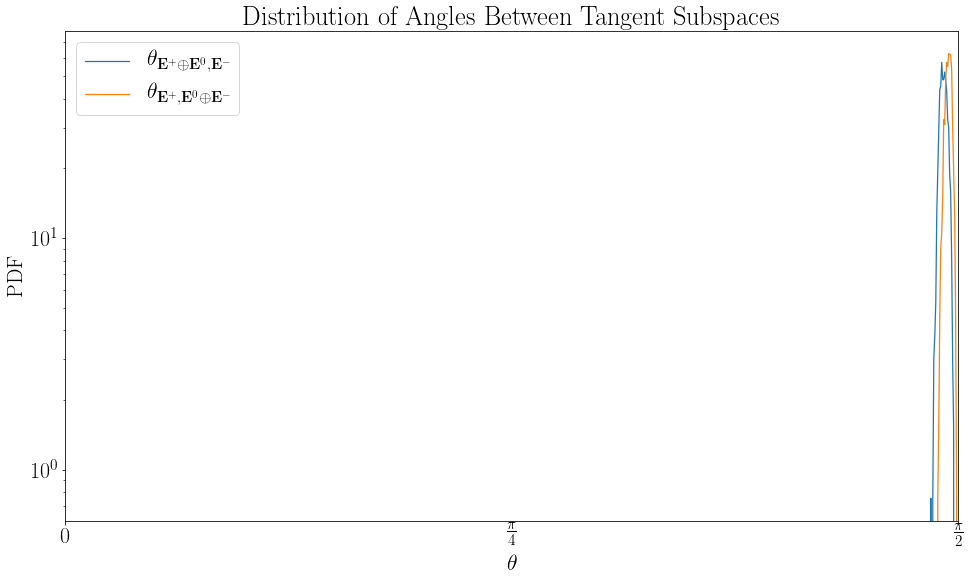

In [26]:
# print(zeroindx)
# print(lce[-1, :])
# print(lce[-1, zeroindx])

# print()
# print(theta1)
# print(theta2)


plt.figure()
hist, bins  = np.histogram(theta1, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
if zeroindx > 0:
    hist, bins  = np.histogram(theta2, range = (0.0, np.pi / 2.0), bins = 900, density = True);
    bin_centers = (bins[1:] + bins[:-1]) * 0.5
    plt.plot(bin_centers, hist)
plt.xlim(0.0, np.pi/2.0)
plt.xlabel(r"$\theta$")
plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
plt.legend([r"$\theta_{1, 2}$", r"$\theta_{1,3}$", r"$\theta_{2,3}$"])
plt.ylabel(r"PDF")
plt.yscale("log")
if zeroindx == 0:
    plt.legend([r"$\theta_{\mathbf{E}^0, \mathbf{E}^-}$"])
else:
    plt.legend([r"$\theta_{\mathbf{E}^+ \oplus \mathbf{E}^0, \mathbf{E}^-}$", r"$\theta_{\mathbf{E}^+, \mathbf{E}^0 \oplus \mathbf{E}^-}$"])
plt.title(r"Distribution of Angles Between Tangent Subspaces")
plt.show()